In [27]:
%matplotlib inline

# RESEARCH IN PYTHON: Regression Discontinuity Analysis
# by J. NATHAN MATIAS March 23, 2015

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

This section is taken from [Chapter 9](http://www.ats.ucla.edu/stat/stata/examples/methods_matter/chapter9/default.htm) of [Methods Matter](http://www.ats.ucla.edu/stat/examples/methods_matter/) by Richard Murnane and John Willett. 

In chapter 9, Murnane and Willett introduce the practice of Regression Discontinuity Analysis, an method for estimating a causal effect in cases where a randomized trial is not possible. 

Regression Discontinuity analysis is possible in cases where some kind of cutoff determines who goes into one group versus another. Instead of looking at the effect of the predictor on the outcome for the entire population, we compare predicted outcomes on both sides of the cutoff.

In *Methods Matter*, the authors use a paper by Joshua Angrist and Victor Lavy: "[Using Maimonides Rule' to Estimate the Effect of Class Size on Scholastic Achievement](http://qje.oxfordjournals.org/content/114/2/533.short)." In this paper, the authors were not able to randomize class size assigment, but they *were* able to take advantage of a rule in Israeli schools that split classes into smaller sizes if the enrollment cohort was 41 or higher. This offered Angrist and Lavy a natural experiment for their research question, since we might expect cohorts on both sides of the cutoff to be very similar, except for the cutoff (the equality of expectation assymption). 

**Regression Discontinuity** analysis uses observations further from the cutoff together with nearer ones "to *project* the estimated treatment effect at the *cut-off*." Practically, this technique regresses the outcome on two predictors:
* a continuous predictor (the **forcing variable**) "that arrays observations (here, classrooms) along a continuum [here, class size] that includes an exogenously defined cut-point. The forcing predictor is usually recentered so it has a value of zero at, or just beyond the cut-point" (180)
* "a dichotomous predictor that specifies on **which side of the exogenously defined cut-off a particular observation lies**, and consequently to which experimental conditions it has been assigned implicitly" (180) (in this example, we construct the variable *small* from class sizes above and below the cut-point)

The assumptions of this approach (beyond the assumptions of regression modeling) are:
* assumption: the cutoff is "as good as random." To test this assumption, we can:
    * verify that there is no selection bias in the application of the cutoff, perhaps with the [McCrary Density test (2008)](http://eml.berkeley.edu/~jmccrary/mccrary2006_DCdensity.pdf) on both sides of the cutoff. See also Urquiola and Verhoogen (2009) "[Class-Size Caps, Sorting, and the Regression-Discontinuity Design](http://www.columbia.edu/~ev2124/research/Urquiola%26VerhoogenAER2009.pdf)," for an in-depth exploration of how to observe these biases.  
    * confirm that there is no unobserved influence (in the case of Angrist & Lavy, the authors consider a possible relationship between the socio-economic status of a region and cohort size)
* assumption: the relationship between the outcome and forcing variable is well modeled, something that is sometimes addressed (like below) by limiting the "bandwidth" observations on both sides of the cutoff. These can be tested with:
    * sensitivity analyses at different bandwidths
    * sensitivity models that adopt a variety of possible functional forms

## About The Angrist & Lavy Dataset
In this analysis, we examine a dataset that includes school level data for:
* *size*: fifth-grade cohort size
* *intended_classsize*: average intended class size for each school
* *observed_classize*: observed average class size for each school
* *read*: average reading achievement in cohort


In [28]:
# THINGS TO IMPORT
# This is a baseline set of libraries I import by default if I'm rushed for time.

import codecs                     # load UTF-8 Content
import json                       # load JSON files
import pandas as pd               # Pandas handles dataframes
import numpy as np                # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns             # Seaborn for beautiful plots
from dateutil import *            # I prefer dateutil for parsing dates
import math                       # transformations
import statsmodels.formula.api as smf  # for doing statistical regression
import statsmodels.api as sm      # access to the wider statsmodels library, including R datasets
from collections import Counter   # Counter is useful for grouping and counting
import scipy

# Acquire Dataset from Methods Matter

In [29]:
import urllib2
import os.path
if(os.path.isfile("class_size.dta")!=True):
    response = urllib2.urlopen("http://www.ats.ucla.edu/stat/stata/examples/methods_matter/chapter9/angrist.dta")
    if(response.getcode()==200):
        f = open("class_size.dta","w")
        f.write(response.read())
        f.close()
class_df = pd.read_stata("class_size.dta")

# Summary Statistics 

In [30]:
print "=============================================================================="
print "                              OVERALL SUMMARY"
print "=============================================================================="
print class_df.describe()

                              OVERALL SUMMARY
              read         size  intended_classize  observed_classize
count  2019.000000  2019.000000        2019.000000        2019.000000
mean     74.379171    77.741951          30.955935          29.935116
std       7.678460    38.810731           6.107924           6.545885
min      34.799999     8.000000           8.000000           8.000000
25%      69.855000    50.000000          27.000000          26.000000
50%      75.379997    72.000000          31.666666          31.000000
75%      79.839996   100.000000          35.666668          35.000000
max      93.860001   226.000000          40.000000          44.000000


# Set up Forcing Variable and Cutoff Predictor

The Forcing Variable (*csize*) is centered around the cutoff, and the cutoff predictor (*small*) is a dichotomous variable that indicates which side of the cutoff an observation lands.

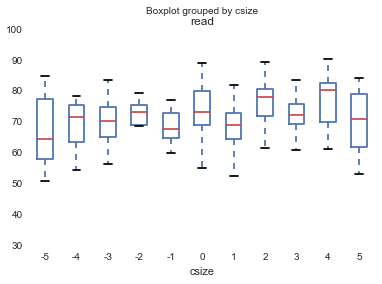

In [34]:
def small(size):
    if(size>=41):
        return 1
    return 0
    
# "first" distinguishes the groups that participate in the first diff.
def first(group):
    groups = {1: 0, 2:0,
              3: 1, 4:1}
    return groups[group]

# SET UP Forcing Variable and Cutoff Predictor
class_df['small'] = class_df['size'].map(small)
class_df['csize'] = class_df['size'].map(lambda x: x-41)

# summarize the read variable by each class size group
class_df[(class_df['size']>=36) & (class_df['size']<=46)].boxplot("read", "csize")
plt.show()

# Regression Discontinuity

                            OLS Regression Results                            
Dep. Variable:                   read   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     3.103
Date:                Mon, 23 Mar 2015   Prob (F-statistic):             0.0459
Time:                        23:57:58   Log-Likelihood:                -1536.6
No. Observations:                 423   AIC:                             3079.
Df Residuals:                     420   BIC:                             3091.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     70.1188      1.151     60.908      0.0

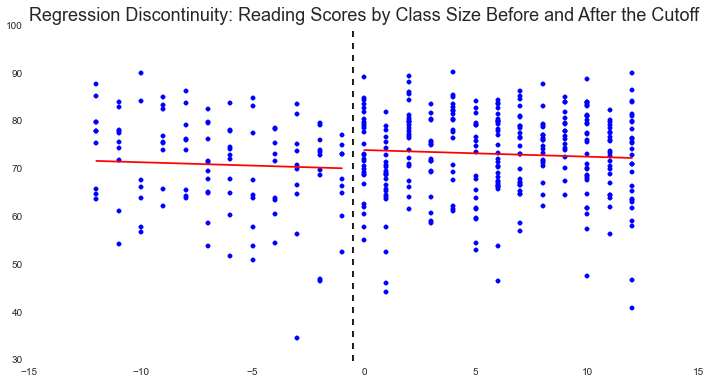

In [36]:
window = class_df[(class_df['size']>=29) & (class_df['size']<=53)]

result = smf.ols(formula = "read ~ csize + small", 
                 data = window).fit()
print result.summary()

plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(window.csize,window.read, color="blue")
l=window[window.csize<0].csize.count()
plt.plot(window.csize[0:l], result.predict()[0:l], '-', color="r")
plt.plot(window.csize[l:], result.predict()[l:], '-', color="r")
plt.axvline(x=-0.5,color="black", linestyle="--")
plt.title("Regression Discontinuity: Reading Scores by Class Size Before and After the Cutoff", fontsize="18")

^^ In this model, we see a statistically significant effect of class size on reading scores (p<0.05), as expressed in the coefficient *small* and illustrated by plotting the predicted value from the model on the forcing variable.

## Generalizing the Relationship Between the Outcome and the Forcing Variable

Murnane and Willett explore a more complex example in Ludwig and Miller (2009) "[Does Head Start Improve Children's Life Chances? Evidence from a Regression Discontinuity Design](http://qje.oxfordjournals.org/content/122/1/159.short)." In this paper, the authors identify a possible exogenous cutoff in the deployment of Head Start when the US Office of Economic Opportunity (OEO) offered Head Start grant-writing support to communities with county-level povery rates below 59.2%. The authors fit two regression discontinuity models:

**Model 1** "examines differences in counties' funding for and participation in, the Head Start program as a consequence of receipt of grant-writing assistance or the lack of it. The results of these analyses showed that grant-writing assistance did indeed lead to differences in Head Start funding and participation immediately following receipt of the assistance." (187)
**Model 2** focused on "longer-term child health and schooling outcomes." In this model, "poverty-rate was again the forcing variable and exogenous assignment to grant-writing assistance again defined the experimental conditions. However, now, the impact of *participating* in Head Start on future child outcomes is the substantive focus, and so grant-writing assistance--which remains the principal question predictor--has become an exogenously assigned expression of *intent to treat* by Head Start" (187). This opens up two causal questions:
* "Did receipt of grant-writing assistance lead to increases in a county's participation in, and funding for, Head Start?" (187) 
* "Did grant-writing assistance (which constitutes an intent to treat with Head Start) lead to improvement in future child outcomes?" (187) (particularly recuding child mortality)

Murnane and Willett walk readers through the various models taken in this paper, as well as the sensitivity analyses conducted on the second set of models:
* demonstrating that their approach "*revealed no effects for outcomes that they hypothesized should not have been influenced by the OEO grant-writing assistance program*" (193)
    * testing unlinked outcomes, like per-capita spending on non-Head-Start programs
    * testing outcomes from a period before the intervention
    
## Planning Regression Discontinuity Designs Up Front
Murnane and Willet note that Regression Discontinuity can be convenient as an initial study design in politically complicated situations: "providing assistance to the 300 poorest counties, with the slightly less needy serving as controls, would be easier to defend ethically to members of Congress who were concerned about equity than would the assignment of poor counties randomly to treatment and control groups" (195). When doing this, there are several costs:
* Results apply only to observations near the cut-point (197)
* Statistical power is also a problem: "the sample size required in an impact evaluation with an RD design typically must be almost three times the size of the sample that would be required in an equivalent random-assignment experiment of the same statistical power" (they cite Bloom, forthcoming, which I couldn't find) (197)

## Further Reading
Murnane and Willett conclude by suggesting that readers further interested in this technique read Thomas Cook's 2008 paper, "[Waiting for Life to Arrive: A History of the Regression-Discontinuity Design in Psychology, Statistics, and Economics](http://www.sciencedirect.com/science/article/pii/S0304407607001108)" in the journal of Econometrics.
